# Métodos Numéricos - Obligatorio 1

## Parte 1

En esta parte de este trabajo se busca resolver el sistema $Ax=b$ por varios métodos.

$$ A = \begin{bmatrix} 29 & 34 & -10 \\ 34 & 41 & -12 \\ -10 & -12 & 24 \end{bmatrix},\ b = \begin{bmatrix} 1 \\ 2 \\ 3 \end{bmatrix}$$

In [2]:
import PyPlot

A = [ 29.  34. -10.;
      34.  41. -12.;
     -10. -12.  24.]

b = [1., 2., 3.]

x_julia = A\b

3-element Array{Float64,1}:
 -0.807692
  0.769231
  0.173077

### Escalerización Gaussiana

In [3]:
function substitucion_hacia_adelante(L::Array{Float64}, b::Array{Float64})
    x = copy(b)
    n = size(b, 1)
    for j = 1:n
        for k = 1:j-1
            x[j] -= x[k] * L[j,k]
        end
        x[j] /= L[j,j]
    end
    x
end

substitucion_hacia_adelante (generic function with 1 method)

In [4]:
function substitucion_hacia_atras(U::Array{Float64}, b::Array{Float64})
    x = copy(b)
    n = size(b, 1)
    for j = n:-1:1
        for k = j+1:n
            x[j] -= x[k] * U[j,k]
        end
        x[j] /= U[j,j]
    end
    x
end

substitucion_hacia_atras (generic function with 1 method)

In [5]:
function escalerizacion_gaussiana(A::Array{Float64}, b::Array{Float64})
    n = size(b, 1)
    p = Array(1:n) # indices de permutacion de filas
    Ab = [A b]
    
    for i = 1:n
        k = i
        while Ab[p[k], i] == 0 # buscamos un pivot no nulo
            k += 1
        end
        if k != i
            p[i], p[k] = p[k], p[i] # permutacion de las filas i y k
        end
        
        for j = i+1:n
            Ab[p[j],:] += -(Ab[p[j],i] / Ab[p[i],i]) * Ab[p[i],:]
        end
    end
    
    U = Ab[p,1:n]
    x = substitucion_hacia_atras(U, Ab[p,n+1])
    x, U
end

escalerizacion_gaussiana (generic function with 1 method)

In [6]:
@time x_gauss, U = escalerizacion_gaussiana(A, b)
display(x_gauss)
display(U)

3-element Array{Float64,1}:
 -0.807692
  0.769231
  0.173077

3×3 Array{Float64,2}:
 29.0  34.0      -10.0     
  0.0   1.13793   -0.275862
  0.0   0.0       20.4848  

  0.441835 seconds (173.59 k allocations: 8.722 MiB)


### Descomposición de Cholesky

Si se tiene que $A = LL^T$, donde L es una matriz triangular inferior, podemos resolver el sistema $Ax=LL^Tx=b$ mediante la resolución de los dos sistemas triangulares $L^Tx=y$ y $Ly=b$. De hecho existe un teorema que afirma la existencia de esta descomposición para matrices simétricas y (semi)-definidas positivas, como es el caso de $A$.

Para calcular $L$ se utiliza la siguiente identidad:

$$ A_0 = H_0 = \begin{bmatrix} d_1 & v_1^T \\ v_1 & \bar{H}_1 \end{bmatrix} = \begin{bmatrix} \sqrt{d_1} & 0 \\ \frac{v_1}{\sqrt{d_1}} & I_{n-1} \end{bmatrix} \begin{bmatrix} 1 & 0 \\ 0 & \bar{H}_1 - \frac{v_1 v_1^T}{d_1} \end{bmatrix} \begin{bmatrix} \sqrt{d_1} & \frac{v_1^T}{\sqrt{d_1}} \\ 0 & I_{n-1} \end{bmatrix} = L_1 \begin{bmatrix} 1 & 0 \\ 0 & H_1 \end{bmatrix} L_1^T$$

Se toma $A_0 = H_0 = A, \ A_1 = \begin{bmatrix} 1 & 0 \\ 0 & H_1 \end{bmatrix}$, etc. Se puede concluir que $A = L_1L_2 \dots L_nL_n^T \dots L_2^TL_1^T = LL^T$ y que la columna $j$ de $L$ es igual a la columna $j$ de $L_j$.

In [7]:
function cholesky(A::Array{Float64})
    n = size(A, 1)
    H = copy(A)
    L = zeros(n, n)
    for k = 1:n
        d = H[k,k]
        v = H[k+1:n,k]
        sd = sqrt(d)
        L[k,k] = sd
        L[k+1:n,k] = v / sd
        H[k+1:n,k+1:n] -= (v * v') / d
    end
    L
end

cholesky (generic function with 1 method)

In [8]:
function solucion_cholesky(A::Array{Float64}, b::Array{Float64})
    L = cholesky(A)
    y = substitucion_hacia_adelante(L, b)
    x = substitucion_hacia_atras(L', y)
    x, L
end

solucion_cholesky (generic function with 1 method)

In [9]:
@time x_cholesky, L = solucion_cholesky(A, b)
display(x_cholesky)
display(L)

3-element Array{Float64,1}:
 -0.807692
  0.769231
  0.173077

3×3 Array{Float64,2}:
  5.38516   0.0       0.0    
  6.31364   1.06674   0.0    
 -1.85695  -0.258603  4.52602

  0.488197 seconds (265.47 k allocations: 12.636 MiB, 2.44% gc time)


## Métodos iterativos

Conocida una relación de la forma $x = Q x + r$, tenemos un método iterativo asociado que parte de un $x_0$ cualquiera y aplica repetidamente la ecuación $x^{(k+1)} = Q x^{(k)} + r$. Si consideramos el error de cada $x^{(k)}$ en la sucesión que se obtiene, podemos ver que se cumple lo siguiente:

$$ e^{(k+1)} = x^{(k+1)} - x = Q x^{(k)}+r - (Q x - r) = Q (x^{(k)} - x) = Q e^{(k)}$$

Entonces el método converge cuando el radio espectral de $Q$ es menor a $1$, ya que cuando esto se cumple el error se reduce linealmente en norma en cada iteración y tiende a cero cuando $k$ aumenta.

Para resolver un sistema $Ax = b$ descomponemos $A$ según $A = L + D + U$, donde $D$ es una matriz diagonal con $D_{ii} = A_{ii}$, $L$ es triangular inferior con $L_{ij} = A_{ij}$ para $j<i$ y $U$ es triangular superior con $U_{ij}$ para $i<j$.

De esta descomposición, despejando de $Ax=(L + D + U)x=b$, surgen los métodos de Jacobi ($x = -D^{-1}(L+U)x + D^{-1}b$) y Gauss-Seidel ($x = -(D+L)^{-1}Ux + (D+L)^{-1}b$).

In [10]:
function jacobi(A::Array{Float64}, b::Array{Float64}, maxiter=100)
    d = diag(A)
    D = diagm(d)
    Dinv = diagm(1./d)
    L = tril(A) - D
    U = triu(A) - D
    Q = -Dinv*(L+U)
    r = Dinv*b
    
    x = zeros(b)
    e = zeros(maxiter)
    for k in 1:maxiter
        x = Q*x + r
        e[k] = norm(x - x_julia)
    end
    x, e
end

@time x_jacobi, err_jacobi = jacobi(A, b)
println("Error relativo Jacobi: ", norm((x_jacobi - x_julia) ./ x_julia))

  1.228023 seconds (735.14 k allocations: 37.009 MiB, 0.81% gc time)
Error relativo Jacobi: 9.788063516619217e6


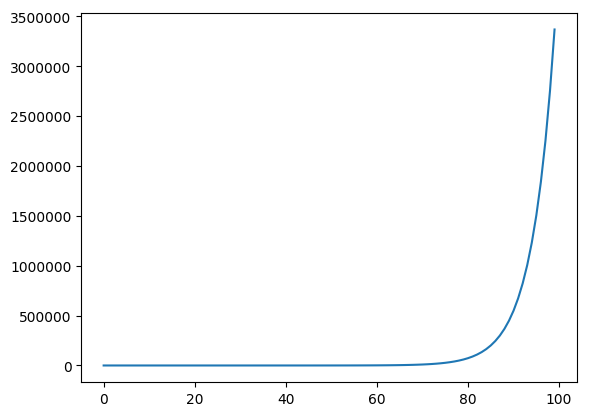

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5b0107c190>

In [11]:
# decir algo sobre la no convergencia de Jacobi...
PyPlot.plot(err_jacobi)

In [12]:
function gauss_seidel(A::Array{Float64}, b::Array{Float64}, maxiter=100)
    d = diag(A)
    D = diagm(d)
    L = tril(A) - D
    U = triu(A) - D
    DLinv = inv(D+L)
    Q = -DLinv*U
    r = DLinv*b
    
    x = zeros(b)
    e = zeros(maxiter)
    for k in 1:maxiter
        x = Q*x + r
        e[k] = norm(x - x_julia)
    end
    x, e
end

x_gauss_seidel, err_gauss_seidel = gauss_seidel(A, b)
println("Error relativo Gauss-Seidel: ", norm((x_gauss_seidel - x_julia) ./ x_julia))

Error relativo Gauss-Seidel: 0.09128784061523743


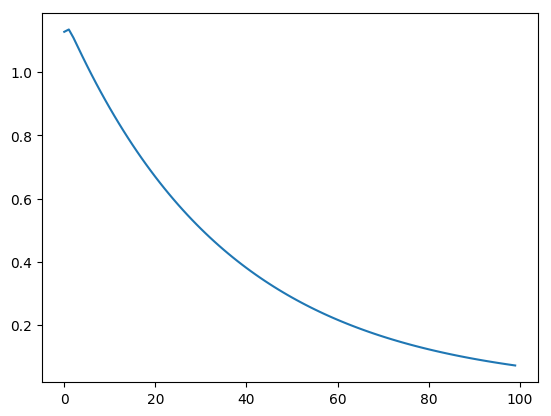

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5b00f79710>

In [13]:
PyPlot.plot(err_gauss_seidel)

## Parte 2

Para resolver los sistemas $Bx=d$ y $Cx=e$, donde $B$ y $C$ son grandes matrices esparsas y simétricas, no podemos usar los métodos que usamos para la matriz $A$ sin modificación, ya que estos requieren $O(n^3)$ operaciones y estos algoritmos demorarían más tiempo del que tenemos disponible. Por eso debemos usar métodos que aprovechen las propiedades de estas matrices: la mayoría de los elementos de $B$ y $D$ son cero, lo que nos permite ahorrarnos aquellas operaciones que podamos concluír que van a resultar cero.

Por ejemplo, si tenemos un vector $v$ de largo $n$ cuyos últimos $n-k$ elementos son nulos, para calcular $vv^T$ solo tenemos que hacer $k^2$ multiplicaciones en lugar de $n^2$, porque sabemos de antemano que $(vv^T)_{ij} = 0$ siempre que $k<i$ o $k<j$.

En el cálculo de la descomposición de Choleski hay que hacer ese mismo cómputo, pero los $v$ cambian en cada iteración. Sin embargo, podemos ver por inducción que se puede acotar el número de elementos no nulos de $v$, y por consiguiente el número de operaciones que requiere el algoritmo. Para esto resulta útil el concepto de ancho de banda $\beta$ de una matriz.

$$\beta_i = \max\{|i-j| : A_{ij} > 0 \} $$

Resulta que si $A$ es una matriz con ancho de banda $\beta$, la matriz que resulta de la descomposición de Cholesky también tiene ancho de banda $\beta$ y los $v$ no tienen más de $\beta$ elementos no nulos en el correr del algoritmo. Esto implica que el algoritmo corre en $O(\frac{1}{2}\beta(\beta + 3)n)$. Por eso es deseable que la matriz tenga un ancho de banda pequeño.

No siempre una matriz esparsa tiene un ancho de banda chico. Por eso se buscan permutaciones de la matriz que reduzcan $\beta$. Un algoritmo para encontrar una permutación conveniente es el de Cuthill-McKee.

In [14]:
# se puede detallar mas porque son ciertas estas cosas
# falta describir la interpretacion de matrices esparsas como grafos y el 
# algoritmo de cuthill mckee.

# para resolver los sistemas esparsos se puede usar B\d y C\e, pero no se cuales son e y d.

Matrices:
* [B: nasa1824][B]
* [C: raefsky][C]

[B]: https://www.cise.ufl.edu/research/sparse/matrices/Nasa/nasa1824.html
[C]: https://www.cise.ufl.edu/research/sparse/matrices/Simon/raefsky4.html

In [15]:
import HarwellRutherfordBoeing;

Brb = HarwellRutherfordBoeing.RutherfordBoeingData("nasa1824/nasa1824.rb")
Crb = HarwellRutherfordBoeing.RutherfordBoeingData("raefsky4/raefsky4.rb")

Rutherford-Boeing data 817 of type rsa
19779 rows, 19779 cols, 674195 nonzeros


In [16]:
B = Hermitian(Brb.data, :L);
C = Hermitian(Crb.data, :L);

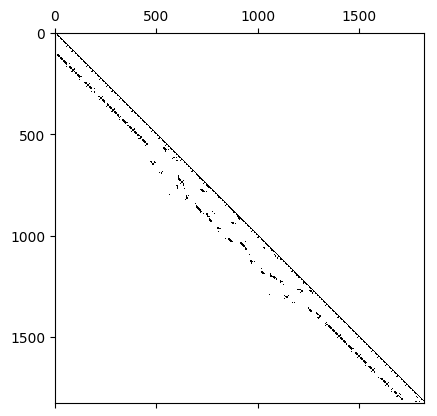

  1.314767 seconds (3.39 M allocations: 53.766 MiB, 19.22% gc time)


PyObject <matplotlib.image.AxesImage object at 0x7f5afcd82dd0>

In [18]:
@time PyPlot.spy(Brb.data)

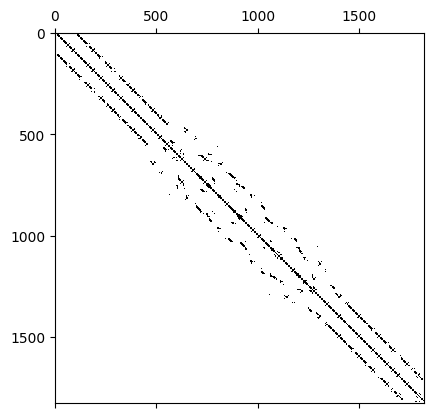

  1.365283 seconds (3.39 M allocations: 54.075 MiB, 11.90% gc time)


PyObject <matplotlib.image.AxesImage object at 0x7f5afce51910>

In [17]:
@time PyPlot.spy(B)

In [29]:
Pkg.add("Erdos")

INFO: Package Erdos is already installed
INFO: METADATA is out-of-date — you may not have the latest version of Erdos
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [43]:
#Graph{T}(B, upper=false, selfedges=true)
import Erdos
using Erdos
T = Graph(Crb.data)
#Graph{T}(B, upper=false, selfedges=true)

Graph{Int64}(19779, 674195)

LoadError: [91mTypeError: Type: in parameter, expected Type, got Erdos.Graph{Int64}[39m